<p align=center>
<img src="assets/cphbanner.png" width=1280>
</p>

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

# **Project 1: Survival Analysis and Prediction [30 points]**

Many clinical trials and observational studies involve following patients for a long time. The primary event of
interest in those studies may include death, relapse, or the onset of a new disease. The follow-up time for a trial
or a study may range from few weeks to many years. To analyze this data, we typically conduct time-to-event
analysis and build predictive models that learn time-to-event distributions. The goal of this project is to test
your ability to conduct basic survival analyses as well as develop ML models for survival prediction.

**Please submit your report and code by <u> Tuesday 2/4 11:59 PST </u>.**

## Task 1.1: Nonparametric Survival Analysis in Heart Failure [7 pts]

Nonparametric models of survival data do not make parametric assumptions on the distribution of timeto-event outcomes. They are widely used in clinical studies to derive descriptive statistics of survival in a population. In this task, we will apply standard nonparametric estimators to analyze survival of heart failure patients in a recent, widely-recognized study [1].

####  Setup and Dataset

The dataset we will use in this task was extracted from the electronic health records (EHRs) of 299 heart failure patients from the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015. The cohort included 105 women and 194 men, and their ages range between 40 and 95 years old. All 299 patients had left ventricular systolic dysfunction and had previous heart failures (HF) that put them in classes III or IV of New York Heart Association (NYHA) classification of the stages of heart failure. The dataset contains 13 features, which report clinical, body, and lifestyle information. The patients were followed up for 130 days on average (maximum follow-up period was 285 days). The event of interest was death during the follow-up period.

The dataset is publicly accessible and was shared with the class through UCSF Box. You can load the dataset in the directory "./data" and inspect all the features/outcomes using pandas as follows:

In [2]:
import os
import pandas as pd
from src.directory import csv_paths

In [3]:
# read data
dataset = pd.read_csv(csv_paths['faisalabad'])

In [4]:
dataset

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:
# descriptive statistics
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
# check for NaN
print(f'NA Count by Variable : {dataset.isna().sum(axis=0)[dataset.isna().sum(axis=0) > 0]}')

NA Count by Variable : Series([], dtype: int64)


## Solution

### Task 1.1.1

In [7]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from lifelines import KaplanMeierFitter
from src.KM_estimator import kaplan_meier
from src.directory import csv_paths
import numpy as np

In [8]:
time_col = 'time'
event_col = 'DEATH_EVENT'
dataset = pd.read_csv(csv_paths['faisalabad'])

# set alpha for confidence intervals
alpha = 0.05

In [9]:
# get KM estimate from scratch
km_df = kaplan_meier(dataset, time_col, event_col, alpha=alpha)

In [10]:
# get KM estimate from lifelines
kmf = KaplanMeierFitter(alpha=alpha)
kmf.fit(dataset['time'], event_observed=dataset['DEATH_EVENT'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 299 total observations, 203 right-censored observations>

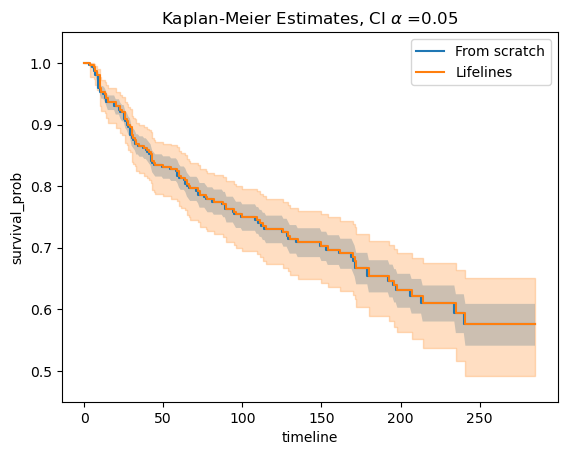

In [11]:
# plot KM estimates from scratch and with lifelines
fig, axs = plt.subplots()

# plot from scratch KM
sns.lineplot(data=km_df, x='time', y='survival_prob', 
             drawstyle='steps-pre', ax=axs, label='From scratch', legend=True)
plt.fill_between(km_df['time'], km_df['ci_lower'], km_df['ci_upper'], alpha=0.3)

# plot lifelines KM
kmf.plot_survival_function(label='Lifelines')

plt.ylim(.45, 1.05)
plt.title(fr'Kaplan-Meier Estimates, CI $\alpha$ ={alpha}')
plt.show()

# check survival function equality
assert all(np.isclose(km_df['survival_prob'].values.ravel(),
                      kmf.survival_function_.reindex(range(km_df['time'].max() +1)).ffill().values.ravel())), 'Survival functions don\'t match!'

### Task 1.1.2

In [12]:
from scipy.optimize import curve_fit

In [13]:
eps = 1e-8

def exp_model(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(f=exp_model, xdata=km_df.index, ydata=km_df['survival_prob'])
S_t = exp_model(km_df.index, *popt)

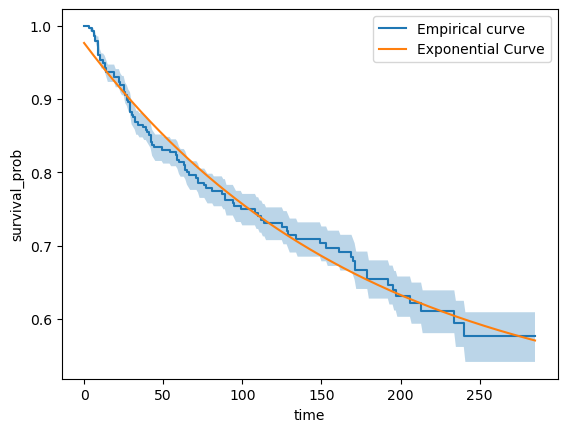

In [14]:
# plot KM estimates from scratch and with lifelines
fig2, axs2 = plt.subplots()

# plot from scratch KM
sns.lineplot(data=km_df, x='time', y='survival_prob', 
             drawstyle='steps-pre', ax=axs2, label='Empirical curve', legend=True)
plt.fill_between(km_df['time'], km_df['ci_lower'], km_df['ci_upper'], alpha=0.3)

axs2.plot(S_t, label='Exponential Curve')
plt.legend()
plt.show()

# Limitation: no guaranteed y==0 at x==0

### Task 1.1.3

C-index: 0.5302506482281764


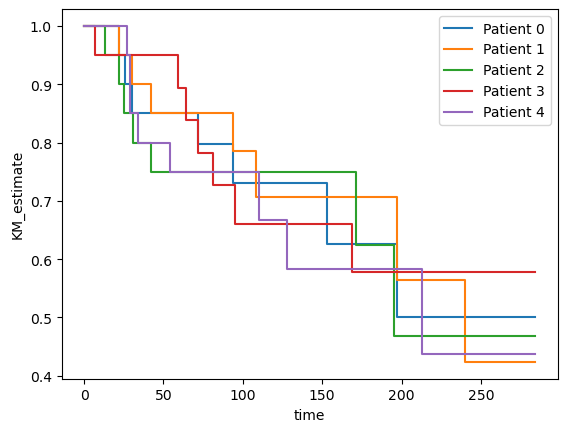

In [15]:
from src.data_dict import feature_config
from src.KM_estimator import nearest_neighbor_km, evaluate_c_index

dataset_name = 'faisalabad'
patient_features = feature_config[dataset_name]
time_col = 'time'
event_col = 'DEATH_EVENT'
max_time = dataset[time_col].max()

patient_km_fits = nearest_neighbor_km(dataset, patient_features, time_col, event_col, n_neighbors=20)

c_index = evaluate_c_index(dataset, patient_km_fits, time_col, event_col)
print(f"C-index: {c_index}")

#Example of getting survival probabilites for a specific patient
fig, axs = plt.subplots()
for patient_index in range(5):
    time_points = np.arange(max_time)
    patient_survival_prob = patient_km_fits[patient_index].survival_function_at_times(time_points)
    patient_survival_prob.index.name = time_col
    
    sns.lineplot(data=patient_survival_prob.reset_index(), x='time', y='KM_estimate', 
                 drawstyle='steps-pre', ax=axs, label=f'Patient {patient_index}', legend=True)

## Task 1.2: Survival Prediction in HF patients using the Cox Model [7 pts]

### Task 1.2.1

In [16]:
import numpy as np
import pandas as pd
from src.data_dict import feature_config
from src.lightning import CoxRiskLightning, get_trainer, get_checkpoint_callback, get_log_dir_path
from src.dataset import SurvivalDataModule

Seed set to 40


In [17]:
time_col = 'time'
event_col = 'DEATH_EVENT'
dataset_name = 'faisalabad'

# set up datamodule
datamodule = SurvivalDataModule(
    dataset_name=dataset_name,
    input_features=feature_config[dataset_name],
    time_col=time_col,
    event_col=event_col
)

# set up model 
model = CoxRiskLightning(
    dataset_name=dataset_name,
    clinical_features=feature_config[dataset_name],
    time_col=time_col,
    event_col=event_col
)

# set log dir
model_name = 'cox'
log_dir_path = get_log_dir_path(model_name)

# get checkpoint callback
checkpoint_callback = get_checkpoint_callback(model_name, log_dir_path)

# get trainer
trainer = get_trainer(model_name, checkpoint_callback)

print("Training model")
trainer.fit(model, datamodule)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model


Processing faisalabad Dataset: 299it [00:00, 10816.87it/s]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | CoxRiskTorch | 12     | train
-----------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [18]:
model_coefficients = model.model.risk.weight.squeeze().detach().numpy()
# print(pd.DataFrame(model_coefficients, index=feature_config[dataset_name], columns=['Model coefficients']))

feature_of_interest = 'age'
idx = model.feature_names.index(feature_of_interest)
effect_of_increment = np.exp(model_coefficients[idx])
print(f'\nHazard Ratio of 1-year increment of {feature_of_interest} on risk:', effect_of_increment)


Hazard Ratio of 1-year increment of age on risk: 1.5197906


### Task 1.2.2

In [19]:
# run train set through model
predict_trainer = get_trainer(model_name, checkpoint_callback)
_ = predict_trainer.predict(model, datamodule)
metrics = model.metric_dict
print('C-index on train set:', metrics['predict']['predict_cindex'])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Processing faisalabad Dataset: 299it [00:00, 29203.08it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

C-index on train set: 0.7424431287005298


### Task 1.2.3

In [20]:
from src.dataset import merge_batches
from src.data_dict import feature_config
from src.lightning import CoxRiskLightning, get_trainer, get_checkpoint_callback, get_log_dir_path
from src.dataset import SurvivalDataModule

In [21]:
time_col = 'time'
event_col = 'DEATH_EVENT'
dataset_name = 'faisalabad'

# set up datamodule
datamodule = SurvivalDataModule(
    dataset_name=dataset_name,
    input_features=feature_config[dataset_name],
    time_col=time_col,
    event_col=event_col
)

# set up model 
model = CoxRiskLightning(
    dataset_name=dataset_name,
    clinical_features=feature_config[dataset_name],
    interaction_features=[('age', 'sex')],
    time_col=time_col,
    event_col=event_col
)

# get log dir
model_name = 'cox_age_sex'
log_dir_path = get_log_dir_path(model_name)

# get checkpoint callback
checkpoint_callback = get_checkpoint_callback(model_name, log_dir_path)

# get trainer
trainer = get_trainer(model_name, checkpoint_callback)

print("Training model")
trainer.fit(model, datamodule)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model


Processing faisalabad Dataset: 299it [00:00, 28539.82it/s]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | CoxRiskTorch | 13     | train
-----------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
X = merge_batches(datamodule.train_dataloader())
X, _, _ = model.get_xtc(X)

In [23]:
# get model coefficient pvalues
model.get_coefficient_pvals(X)

{'pval_age': 0.7532665816223898,
 'pval_anaemia': 0.8700404623471534,
 'pval_creatinine_phosphokinase': 0.9387867020419305,
 'pval_diabetes': 0.5102732864679984,
 'pval_ejection_fraction': 0.534337884413755,
 'pval_high_blood_pressure': 0.9442999638843415,
 'pval_platelets': 0.9247167957113667,
 'pval_serum_creatinine': 0.7048116176801236,
 'pval_serum_sodium': 0.9121651373650836,
 'pval_sex': 0.5184208595952133,
 'pval_smoking': 0.7323185454885612,
 "pval_('age', 'sex')": 0.8076853114712716}

## Task 1.3: Deep Survival Prediction for Heart Transplantation [8 pts]

####  Setup and Dataset

For this task, we will use data collected by the United Network for Organ Sharing (UNOS) [2], a non-profit organization that administers the only Organ Procurement and Transplantation Network (OPTN) in the US. UNOS is involved in many aspects of the organ transplant and donation process in the US, including data collection and maintenance, providing assitance to patients and care takers, and informing policy makers on the best use of the limited supply of organs and give all patients a fair chance at receiving the organ they need. UNOS manages the heart transplant waiting list, i.e., the list of terminally-ill patients waiting for donor heart. In order to determine the order of priority for receipt of a donor heart, individuals are classified by degrees of severity for a donor heart, blood type, body weight, and geographic location.

This Task will focus on the cohort of terminally-ill patients who are enrolled in the wait-list for heart transplantation. In this setup, our goal is to predict the patients who are less likely to survive in order to prioritize them for receiving donated organs. The UNOS data covers 30 years of heart transplantation data in the US, spanning the years from 1985 to 2015. We will use data for patients who were on the wait-list for heart transplantation in the US from 1985 to 2010 (27,926 patients) to train an ML-based model for predicting individual-level survival. A held-out test set of 8,403 patients enrolled in the wait-list between 2010 and 2015 will be used by the instructor to evaluate your model. You can load the UNOS data in pandas as follows.

In [24]:
import pandas as pd
from src.directory import csv_paths

In [25]:
UNOS_data = pd.read_csv(csv_paths['unos'])

In [26]:
UNOS_data

,Unnamed: 0,wl_id_code,init_age,gender,hgt_cm_tcr,wgt_kg_tcr,diab,prev_tx,num_prev_tx,ventilator_tcr,...,days_stat2,days_stat1b,init_bmi_calc,vad_while_listed,tah,inotropic,init_date,end_date,Censor (Censor = 1),Survival Time
0,0,190772,58,1,168.00,70.0000,0,0,0,0,...,0,0,24.801587,0,0,0,2/28/1994,3/25/1994,0,25
1,1,763510,0,1,53.00,3.7000,0,1,1,0,...,0,0,13.171947,0,0,0,2/28/1994,3/2/1994,1,2
2,2,39269,39,1,160.00,80.0000,0,0,0,0,...,112,0,31.250000,0,0,0,3/2/1994,6/18/1999,0,1934
3,3,656721,41,1,170.18,63.9600,0,0,0,0,...,428,0,22.084696,0,0,0,1/23/1991,7/25/1997,0,2375
4,4,196059,22,1,165.00,61.0000,0,0,0,0,...,536,0,22.405877,0,0,0,11/11/1992,5/20/1994,0,555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27921,36295,90064,58,0,165.00,64.0000,0,0,0,0,...,0,0,23.507805,0,0,0,1/19/2008,1/21/2008,1,2
27922,36296,579733,64,1,175.26,112.0373,1,0,0,0,...,0,137,36.475144,0,0,0,3/3/2009,11/23/2009,0,265
27923,36300,769462,66,0,172.72,63.5030,0,0,0,0,...,421,0,21.286732,0,0,0,3/3/2009,5/11/2010,1,434
27924,36303,208288,45,1,175.26,79.8322,1,0,0,0,...,61,0,25.990371,0,0,0,3/3/2009,5/3/2009,0,61


In [27]:
UNOS_data.describe()

,Unnamed: 0,wl_id_code,init_age,gender,hgt_cm_tcr,wgt_kg_tcr,diab,prev_tx,num_prev_tx,ventilator_tcr,...,days_stat1,days_stat1a,days_stat2,days_stat1b,init_bmi_calc,vad_while_listed,tah,inotropic,Censor (Censor = 1),Survival Time
count,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,...,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000,27926.000000
mean,14331.355368,446173.839719,44.312182,0.761835,164.429012,75.524876,0.220511,0.057151,0.059443,0.086371,...,31.443923,4.534377,230.429958,20.754458,26.068502,0.022058,0.002149,0.084079,0.407899,580.340614
std,8728.196818,255814.003693,19.009698,0.425968,32.519173,28.273276,0.414599,0.232135,0.252424,0.280916,...,120.339654,23.287038,446.038718,111.115910,8.497129,0.146876,0.046303,0.277512,0.491453,927.873549
min,0.000000,8.000000,0.000000,0.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.907029,0.000000,0.000000,0.000000,0.000000,-2063.000000
25%,6981.250000,226129.500000,37.000000,1.000000,165.000000,65.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,22.215556,0.000000,0.000000,0.000000,0.000000,34.000000
50%,13962.500000,447742.500000,50.000000,1.000000,173.000000,79.830000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.000000,0.000000,26.054160,0.000000,0.000000,0.000000,0.000000,193.000000
75%,20943.750000,665696.750000,58.000000,1.000000,180.340000,92.986400,0.000000,0.000000,0.000000,0.000000,...,16.000000,0.000000,276.000000,0.000000,29.971368,0.000000,0.000000,0.000000,1.000000,709.750000
max,36308.000000,897359.000000,87.000000,1.000000,218.440000,343.000000,1.000000,1.000000,9.000000,1.000000,...,2663.000000,891.000000,6571.000000,2663.000000,755.363907,1.000000,1.000000,1.000000,1.000000,9614.000000


In [28]:
print(f'NA Count by Variable : {UNOS_data.isna().sum(axis=0)[UNOS_data.isna().sum(axis=0) > 0]}')

NA Count by Variable : Series([], dtype: int64)


#### Feature Dictionary

Each patient's record in the UNOS database is associated with the following variables:

In [29]:
patient_variables   = ["init_age", "gender", "hgt_cm_tcr", "wgt_kg_tcr", "diab", "ventilator_tcr",
                       "ecmo_tcr", "most_rcnt_creat", "abo_A", "abo_B", "abo_O", "vad_while_listed",
                       "days_stat1", "days_stat1a", "days_stat2", "days_stat1b", "iabp_tcr",
                       "init_bmi_calc", "tah", "inotropic", "Censor (Censor = 1)", "Survival Time"]

The interpretation of each variable is provided below:

- "init_age": Patient's age at time of enrolling in the wait-list
- "gender": Patient's biological sex
- "hgt_cm_tcr": Patient's height in cm
- "wgt_kg_tcr": Patient's weight in kgs
- "diab": Indication on whether or not the patient is diabetic
- "abo_A": Indication on whether patient's blood type is A
- "abo_B": Indication on whether patient's blood type is B
- "abo_O": Indication on whether patient's blood type is O
- "ventilator_tcr": Indication on whether the patient was dependent on a ventilator at time of enrollment in the wait-list
- "ecmo_tcr": Indication on whether the patient was treated with ECMO (extracorporeal membrane oxygenation) by the time they where enrolled in the wait-list. ECMO is an artificial life support that continuously pumps blood out of the patient's body and sends it through a series of devices that add oxygen and remove carbon dioxide, pumping the blood back to the patient. It is used for a patient whose heart and lungs are not functioning properly.  
- "most_rcnt_creat": Creatinine level in the patient's most recent blood test before enrolling in wait-list.
- "vad_while_listed": Whether the patient was on ventricular assist device (VAD) support when listed for a heart transplant. VAD is a mechanical pump used to restore cardiac function by pumping blood from the lower chambers of the heart to the rest of the body.
- "iabp_tcr": Whether the patient was on Intra-Aortic Balloon Pump (IABP) Therapy. This is a therapeutic device used to improve blood flow when the heart is unable to pump enough blood for your body.
- "init_bmi_calc": Patient's Body Mass Index at time of enrollment in the wait-list.
- "tah": Whether the patient underwent a total artificial heart (TAH) surgery. This is a mechanical pump that replaces the heart when it is not working as it should.
- "inotropic": Whether the patient was on an Inotropic drug at time of enrollment in wait-list. These are medicines that change the force of the heart's contractions.
- "days_stat1", "days_stat1a", "days_stat1b", "days_stat2": UNOS has an internal system for classifying the priority of patients for receiving a heart transplant. Individuals classified as Status 1A have the highest priority on the heart transplant waiting list. Status 1A are individuals who must stay in the hospital as in-patients and require high doses of intravenous drugs, require a VAD for survival, are dependent on a ventilator or have a life expectancy of a week or less without a transplant. Individuals classified as Status 1B are generally not required to stay in the hospital as in-patients. All other candidates for the transplant are listed under Status 2. These variables indicate the number of days a patient spends in each status during the time between their enrollment in the wait-list and death or reception of a transplant.
- "Censor (Censor = 1)": Indication of censoring
- "Survival Time": Time between enrollment in wait-list and death

### Task 1.3.2

In [30]:
import numpy as np
import pandas as pd
from src.data_dict import feature_config
from src.directory import csv_paths, deep_survival_model_path
from src._torch import DeepSurvival
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

In [31]:
event_col = "Censor (Censor = 1)"
time_col = "Survival Time"

UNOS_data = pd.read_csv(csv_paths['unos'])
X = UNOS_data[feature_config['unos']].to_numpy()
T = UNOS_data[time_col].to_numpy()
C = UNOS_data[event_col].to_numpy()
n_features = X.shape[1]

X_train, X_test, T_train, T_test, C_train, C_test = train_test_split(X, T, C, test_size=.2, random_state=40)

In [32]:
torch.manual_seed(40)
model = DeepSurvival(save_path=deep_survival_model_path)
model.fit(X_train, T_train, C_train, lr=3e-2)

11 negative time samples found. Adjusting by setting t == 0.


Training DeepSurvival, epoch 8/1000, val_loss:5.593338895540544, train_loss:5.646255886971487:   1%|          | 8/1000 [00:13<27:42,  1.68s/it]  

Early stopping triggered at epoch 9


In [33]:
# check test c_index
cindex = model.get_cindex(X_test, T_test, C_test)
print('C-index on test set:', cindex.item())

C-index on test set: 0.6838601794569438


In [34]:
predictions = model.predict(X, max_years=10)

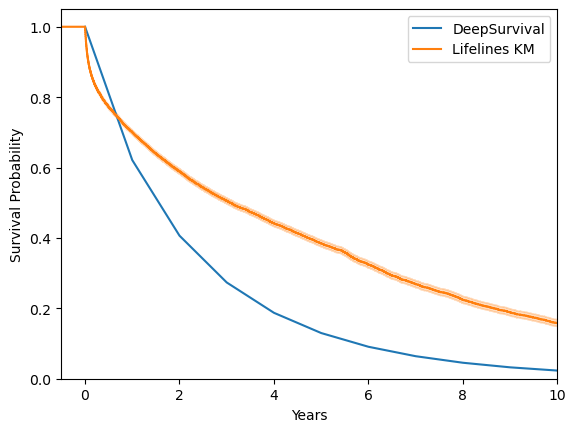

In [35]:
# plot mean survival curve
plt.plot(predictions.mean(axis=0), label='DeepSurvival')

# plot KM survival curve
kmf = KaplanMeierFitter()
kmf.fit(UNOS_data[time_col]/365, event_observed=UNOS_data[event_col])
kmf.plot_survival_function(label='Lifelines KM')

# adjust plot
plt.xlim((-0.5, 10))
plt.ylim((0,1.05))
plt.xlabel("Years")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

## Task 1.4: Handling Informative Censoring via Domain Adaptation [8 pts]

### Task 1.4.1

In [36]:
from pycox import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from src.informative_censoring import check_informative_censoring, generate_semi_synthetic_dataset

In [37]:
# Note: "['Unnamed: 0'] not found in axis" error received reading in flchain & nwtco:
# To fix error: replace the following lines pycox/datasets/from_rdatasets.py:
# line 78: .drop(['chapter', 'Unnamed: 0', 'rownames'], axis=1, errors='ignore')
# line 146: .drop(['Unnamed: 0', 'seqno', 'instit', 'histol', 'study', 'rownames'], axis=1, errors='ignore'))

dataset_dict = dict(zip(['flchain', 'gbsg', 'metabric', 'nwtco'], 
                         [datasets.flchain.read_df(), 
                          datasets.gbsg.read_df(), 
                          datasets.metabric.read_df(), 
                          datasets.nwtco.read_df()]))

for name, dataset in dataset_dict.items():
    dataset.name = name
    

time_col_dict = dict(zip(dataset_dict.keys(),
                         ['futime',
                          'duration',
                          'duration',
                          'edrel']))

event_col_dict = dict(zip(dataset_dict.keys(),
                         ['death',
                          'event',
                          'event',
                          'rel']))

In [38]:
# check for informative censoring
results = {}
for name, dataset in dataset_dict.items():
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    results[name] = check_informative_censoring(dataset, time_col, event_col)

# print results
for name, r in results.items():
    print(name, '\n', r.loc[['informative_censoring']].T, '\n')

flchain 
 feature           informative_censoring
spearmanr_results                  True
mgus                               True
creatinine                         True
futime                             True
sex                               False
lambda                             True
sample.yr                          True
flc.grp                            True
kappa                              True 

gbsg 
 feature           informative_censoring
spearmanr_results                  True
x3                                 True
x0                                 True
x2                                 True
duration                           True
x6                                False
x5                                 True
x1                                 True 

metabric 
 feature           informative_censoring
spearmanr_results                 False
x3                                 True
x0                                 True
x8                                 True
x7      

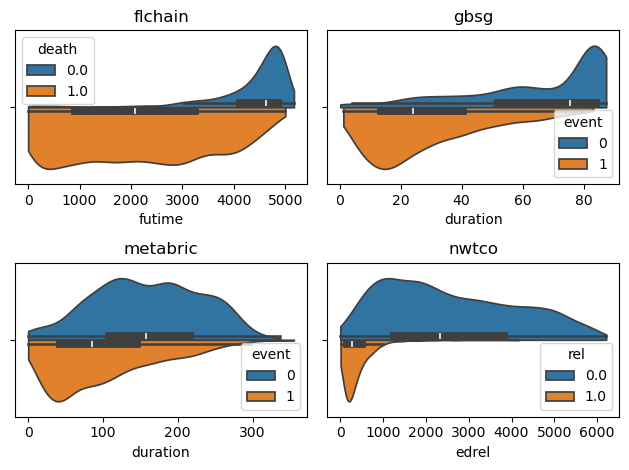

In [39]:
# visually inspect time-dependent censoring
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for i, (name, dataset) in enumerate(dataset_dict.items()):
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    sns.violinplot(dataset, x=time_col, hue=event_col, ax=axs[i], split=True, cut=0)
    axs[i].set_title(name)

plt.tight_layout()

In [40]:
# generate semi synthetic data
synthetic_data = {}
for name, dataset in dataset_dict.items():
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    synthetic_data[name] = generate_semi_synthetic_dataset(dataset, time_col, event_col, max_loops=10)
    synthetic_data[name].name = name

Creating semi-synthetic dataset for flchain
Fraction of original uncensored events censored: 0.906
Spearman r correlation p-value between time_col and event_col: 0.051

Creating semi-synthetic dataset for gbsg
Fraction of original uncensored events censored: 0.656
Spearman r correlation p-value between time_col and event_col: 0.056

Creating semi-synthetic dataset for metabric
Fraction of original uncensored events censored: 0.436
Spearman r correlation p-value between time_col and event_col: 0.051

Creating semi-synthetic dataset for nwtco
Fraction of original uncensored events censored: 0.974
Spearman r correlation p-value between time_col and event_col: 0.066



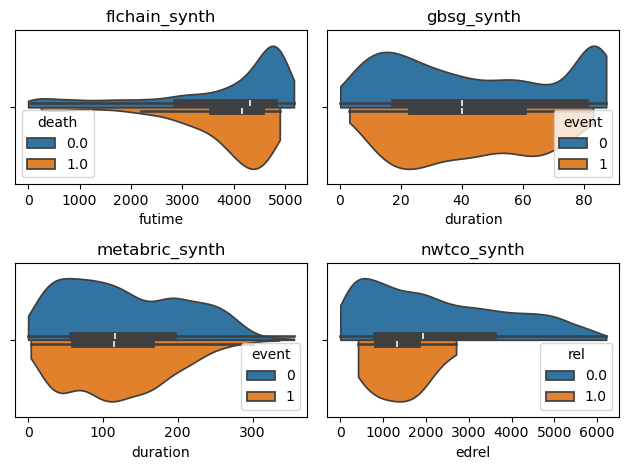

In [41]:
# visually inspect time-dependent censoring
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for i, (name, dataset) in enumerate(synthetic_data.items()):
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    sns.violinplot(dataset, x=time_col, hue=event_col, ax=axs[i], split=True, cut=0)
    axs[i].set_title(f'{name}_synth')

plt.tight_layout()

In [42]:
# check for informative censoring
results = {}
for name, dataset in synthetic_data.items():
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    results[name] = check_informative_censoring(dataset, time_col, event_col)

# print results
for name, r in results.items():
    time_col = time_col_dict[name]
    print(f'{name}_synth', '\n', r.loc[['informative_censoring']].T, '\n')

flchain_synth 
 feature           informative_censoring
spearmanr_results                  True
mgus                              False
creatinine                        False
futime                            False
sex                                True
lambda                            False
sample.yr                          True
flc.grp                           False
kappa                             False 

gbsg_synth 
 feature           informative_censoring
spearmanr_results                 False
x3                                False
x0                                False
x2                                False
duration                          False
x6                                False
x5                                False
x1                                False 

metabric_synth 
 feature           informative_censoring
spearmanr_results                 False
x3                                 True
x0                                 True
x8                            

### Task 1.4.2

In [43]:
import torch
from src._torch import DeepSurvival
from src.directory import deep_survival_model_path
from sklearn.model_selection import train_test_split

In [44]:
# modified modal with importance weighting ERM
for name, dataset in synthetic_data.items():

    # set up data
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    feature_cols = list(set(dataset.columns) - set([time_col, event_col]))

    X = dataset[feature_cols].to_numpy()
    T = dataset[time_col].to_numpy()
    C = dataset[event_col].to_numpy()
    n_features = X.shape[1]

    # split data
    X_train, X_test, T_train, T_test, C_train, C_test = train_test_split(X, T, C, test_size=.2, random_state=40)

    # get save path
    save_path = os.path.join(os.path.dirname(deep_survival_model_path), f'best_model_DA_{name}.pth')

    # init and train model
    torch.manual_seed(40)
    model = DeepSurvival(dataset_name=name,
                         save_path=save_path,
                         clinical_features=feature_cols,
                         importance_weighting=True)
    model.fit(X_train, T_train, C_train)

    # check test c_index
    cindex = model.get_cindex(X_test, T_test, C_test)
    print(f'C-index on {name}_synth test set:', cindex.item(), '\n')

Training DeepSurvival, epoch 11/1000, val_loss:5.219508240607915, train_loss:5.258990948844884:   1%|          | 11/1000 [00:00<01:16, 12.87it/s] 


Early stopping triggered at epoch 12
C-index on flchain_synth test set: 0.693749737295616 



Training DeepSurvival, epoch 7/1000, val_loss:5.221155983094774, train_loss:6.01134874950787:   1%|          | 7/1000 [00:00<01:19, 12.56it/s] 


Early stopping triggered at epoch 8
C-index on gbsg_synth test set: 0.6010731295592934 



Training DeepSurvival, epoch 54/1000, val_loss:4.698391103313605, train_loss:5.28123012233431:   5%|▌         | 54/1000 [00:04<01:26, 10.92it/s]  


Early stopping triggered at epoch 55
C-index on metabric_synth test set: 0.6740543969550392 



Training DeepSurvival, epoch 9/1000, val_loss:6.910130288745114, train_loss:4.4237865710220206:   1%|          | 9/1000 [00:00<00:28, 34.47it/s]


Early stopping triggered at epoch 10
C-index on nwtco_synth test set: 0.4182076813655761 



In [45]:
# original model
for name, dataset in synthetic_data.items():

    # set up data
    time_col, event_col = time_col_dict[name], event_col_dict[name]
    feature_cols = list(set(dataset.columns) - set([time_col, event_col]))

    X = dataset[feature_cols].to_numpy()
    T = dataset[time_col].to_numpy()
    C = dataset[event_col].to_numpy()
    n_features = X.shape[1]

    # split data
    X_train, X_test, T_train, T_test, C_train, C_test = train_test_split(X, T, C, test_size=.2, random_state=40)

    # get save path
    save_path = os.path.join(os.path.dirname(deep_survival_model_path), f'best_model_{name}.pth')

    # init and train model
    torch.manual_seed(40)
    model = DeepSurvival(dataset_name=name,
                         save_path=save_path,
                         clinical_features=feature_cols,
                         importance_weighting=False)
    model.fit(X_train, T_train, C_train)

    # check test c_index
    cindex = model.get_cindex(X_test, T_test, C_test)
    print(f'C-index on {name}_synth test set:', cindex.item(), '\n')

Training DeepSurvival, epoch 15/1000, val_loss:5.294374988646802, train_loss:5.188808263947586:   2%|▏         | 15/1000 [00:00<00:57, 17.11it/s]


Early stopping triggered at epoch 16
C-index on flchain_synth test set: 0.7174982136101887 



Training DeepSurvival, epoch 7/1000, val_loss:5.076853608938227, train_loss:5.820817160406741:   1%|          | 7/1000 [00:00<01:13, 13.46it/s] 


Early stopping triggered at epoch 8
C-index on gbsg_synth test set: 0.6014348586242237 



Training DeepSurvival, epoch 46/1000, val_loss:4.649413982331081, train_loss:5.2285249231077175:   5%|▍         | 46/1000 [00:03<01:18, 12.14it/s] 


Early stopping triggered at epoch 47
C-index on metabric_synth test set: 0.6800015859170565 



Training DeepSurvival, epoch 7/1000, val_loss:5.90818110951235, train_loss:4.403073173499289:   1%|          | 7/1000 [00:00<00:31, 31.83it/s]  


Early stopping triggered at epoch 8
C-index on nwtco_synth test set: 0.38975817923186346 



## References

[1] Chicco, Davide, and Giuseppe Jurman. “Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone.” BMC Medical Informatics and Decision Making, vol.
20, no. 1 (2020): 1-16.

[2] Weiss, Eric S., Lois U. Nwakanma, Stuart B. Russell, John V. Conte, and Ashish S. Shah. “Outcomes in
bicaval versus biatrial techniques in heart transplantation: an analysis of the UNOS database.” The Journal
of heart and lung transplantation, vol. 27, no. 2 (2008): 178-183.